# Deep Learning &mdash; Assignment 4

Fourth assignment for the 2021 Deep Learning course (NWI-IMC058) of the Radboud University.

_Twan van Laarhoven (tvanlaarhoven@cs.ru.nl) and Gijs van Tulder (g.vantulder@cs.ru.nl)_

_September 2021_


**Names:** Ilias Mourikis, Reza Shokrzad

**Group:** 50

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Train and modify a transformer network
2. Experiment with a translation dataset

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` for PyTorch,
* `d2l`, the library that comes with the [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

In [ ]:
!pip install d2l

In [27]:
from d2l import torch as d2l
import math
import numpy as np
import torch
from torch import nn

## 4.1 Reproducing a transformer

There is a detailed description of the transformer model in chapters 10.5, 10.6 and 10.7 of the d2l book. In this exercise we will do experiments with variations on this model.

**(A) Read d2l chapters 10.5, 10.6 and 10.7. Copy the relevant class definitions below, and run it to train a transformer model on a English->French toy translation dataset**  
Note 1: The functions in each chapter of the book use the library versions (prefixed with `d2l.`) of the functions from other chapters. If you want to make modifications later on, make sure to refrence your own version.  
Note 2: Make sure that you use the pytorch version.

In [56]:
# TODO: your code here
class MultiHeadAttention(nn.Module):
    """Multi-head attention."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of `queries`, `keys`, or `values`:
        # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`)
        # Shape of `valid_lens`:
        # (`batch_size`,) or (`batch_size`, no. of queries)
        # After transposing, shape of output `queries`, `keys`, or `values`:
        # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
        # `num_hiddens` / `num_heads`)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for
            # `num_heads` times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)

        # Shape of `output`: (`batch_size` * `num_heads`, no. of queries,
        # `num_hiddens` / `num_heads`)
        output = self.attention(queries, keys, values, valid_lens)

        # Shape of `output_concat`:
        # (`batch_size`, no. of queries, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)
        
def transpose_qkv(X, num_heads):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`).
    # Shape of output `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_heads`,
    # `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # Shape of output `X`:
    # (`batch_size`, `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    X = X.permute(0, 2, 1, 3)

    # Shape of `output`:
    # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """Reverse the operation of `transpose_qkv`."""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [57]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [58]:
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))
        
# AddNorm class using a residual connection followed by layer normalization
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

# contains two sublayers: multi-head self-attention and positionwise feed-forward networks
class EncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(key_size, query_size,
                                                value_size, num_hiddens,
                                                num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

class TransformerEncoder(d2l.Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

class DecoderBlock(nn.Module):
    # The `i`-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = torch.arange(1, num_steps + 1,
                                          device=X.device).repeat(
                                              batch_size, 1)
        else:
            dec_valid_lens = None

        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of `enc_outputs`:
        # (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.031, 4692.4 tokens/sec on cuda:0


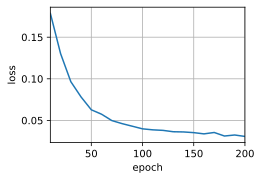

In [31]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

The example in the book uses a function `d2l.load_data_nmt` to load an English->French translation dataset. This function is implemented in chapter 9.5. This implementation produces only a single iterator over batches of data.

**(B) Modify this function to randomly split the data into a training and validation set.**

In [32]:
def load_data_nmt(batch_size, num_steps, train_fraction=0.8, num_examples=1000):
    text = d2l.preprocess_nmt(d2l.read_data_nmt())
    source, target = d2l.tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = d2l.build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = d2l.build_array_nmt(target, tgt_vocab, num_steps)
    # TODO: modify this num_code to produce a training and validation set
    # Hint: use torch.randperm

    # random order (indices permutation)
    indices = torch.randperm(len(src_array)).tolist()
    #updates
    src_array = src_array[indices] 
    src_valid_len = src_valid_len[indices] 
    tgt_array = tgt_array[indices] 
    tgt_valid_len = tgt_valid_len[indices] 
    print('len(src_array):', len(src_array) , 'len(tgt_array): ', len(tgt_array))

    # data splitting
    train_size = int(train_fraction * num_examples)
    val_size = int((1-train_fraction) * num_examples)


    train_dataset = src_array[:train_size]
    train_labels = tgt_array[:train_size]
    train_dataset_valid_len = src_valid_len[:train_size]
    train_labels_valid_len = tgt_valid_len[:train_size]

    val_dataset = src_array[train_size : train_size+val_size+1]
    val_labels = tgt_array[train_size : train_size+val_size+1]
    val_dataset_valid_len = src_valid_len[train_size : train_size+val_size+1]
    val_labels_valid_len = tgt_valid_len[train_size : train_size+val_size+1]

    # Construct a PyTorch data iterator.
    train_arrays = (train_dataset, train_dataset_valid_len, 
                    train_labels, train_labels_valid_len)
    val_arrays = (val_dataset, val_dataset_valid_len,
                  val_labels, val_labels_valid_len)

    train_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(*train_arrays),
                                             batch_size, shuffle=False)
    val_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(*val_arrays),
                                             batch_size, shuffle=False)

    return train_iter, val_iter, src_vocab, tgt_vocab

With a validation set in hand, we can make more informed decisions when comparing different models. The simplest metric to implement is validation set loss. Just like in previous weeks, it would be nice to plot the validation metrics during training. To do that we will need to modify the `d2l.train_seq2seq` function, which is defined in chapter 9.7.

**(C) Complete the implementation below**

In [33]:
def train_seq2seq(net, train_iter, validation_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU or type(m) == nn.LSTM:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = d2l.MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            legend=['train loss', 'validation loss'],
                            #xlim=[10, num_epochs])
                            xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in train_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if epoch < 10 or (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1], None))
            validation_loss = calculate_validation_loss(net, loss, validation_iter, tgt_vocab, device)
            animator.add(epoch + 1, (None, validation_loss))
    print(f'train loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'validation loss {validation_loss:.3f} '
          f'tokens/sec on {str(device)}')

def calculate_validation_loss(net, loss, validation_iter, tgt_vocab, device):
    # TODO: your code here
    # Hint: look at the training code
    loss = d2l.MaskedSoftmaxCELoss()
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for batch in validation_iter:
        X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
        bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
        dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
        Y_hat, _ = net(X, dec_input, X_valid_len)
        l = loss(Y_hat, Y, Y_valid_len)
        # l.sum().backward()  # Make the loss scalar for `backward`
        # d2l.grad_clipping(net, 1)
        num_tokens = Y_valid_len.sum()
        with torch.no_grad():
            metric.add(l.sum(), num_tokens)
    return metric[0] / metric[1]

**(D) Re-train the transformer model, this time showing validation set loss. How does this compare to training set loss?**

train loss 0.024, 3891.4 validation loss 0.286 tokens/sec on cuda:0


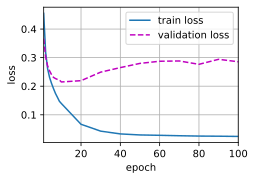

In [34]:
# TODO: your code here
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.0, 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, validation_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, validation_iter, lr, num_epochs, tgt_vocab, device)

TODO: your observations here

Both train and validation loss decline at the initial epochs of training. Followingly, the training loss continues to decrease while the validation loss cannot getting improved. It means that the model does not work well in the generalizing task. Even after initial epochs, we can see the overfitting footprint. 

**(E) Does the validation loss describe how well the model is able to translate unseen sentences or unseen words? What is the difference?**

TODO: your answer here

The model that we built is a Sequence-to-Sequence model, i.e., the model gets a sentence as input and translates this to another sentence. As a result, the validation loss is the error the model produces while is translating an unseen sentence. 

Regarding the difference, the word-level model translates a sentence word by word, while the other model translates the whole sentence. So, they are also different in the accuracy of the output. In the first case, the model tries to minimize the error while just translating a word, but is running the risk for the translated sentence to make sense, even if each word has been translated correctly. 

**(F) During training, the target output Y is also passed into the network (via `dec_input`). What is this used for? And is it possible for the network to 'cheat' by using this input?**

TODO: your answer here

Teacher Forcing is a typical way to improve the model's learning. Training with Teacher Forcing converges faster. The predictions of the model are poor at the initial steps of training. So, we would have cumulative errors, in the following stages, without this method. Besides, it would be cheating if we used the technique in the validation phase. 


## 4.2 Data size

The model is only trained on 1000 sentence pairs. You can change this with the `num_examples` parameter to `load_data_nmt`.

**(A) Train with a larger dataset (at least 5000 samples)**

Tip: Give the network a different variable name in each experiment, then you can re-used earlier trained networks later on.

train loss 0.036, 7380.7 validation loss 0.279 tokens/sec on cuda:0


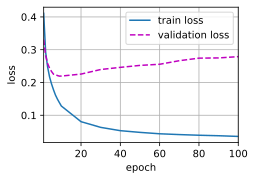

In [35]:
# TODO: your code here
num_hiddens2, num_layers2, dropout2, batch_size2, num_steps2 = 32, 2, 0.0, 64, 10
lr2, num_epochs2, device2 = 0.005, 100, d2l.try_gpu()
ffn_num_input2, ffn_num_hiddens2, num_heads2 = 32, 64, 4
key_size2, query_size2, value_size2 = 32, 32, 32
norm_shape2 = [32]

# load_data_nmt(batch_size, num_steps, train_fraction=0.8, num_examples=10000)
train_iter2, validation_iter2, src_vocab2, tgt_vocab2 = load_data_nmt(batch_size2, num_steps2, num_examples=10000)

encoder2 = TransformerEncoder(len(src_vocab2), key_size2, query_size2, value_size2,
                             num_hiddens2, norm_shape2, ffn_num_input2,
                             ffn_num_hiddens2, num_heads2, num_layers2, dropout2)
decoder2 = TransformerDecoder(len(tgt_vocab2), key_size2, query_size2, value_size2,
                             num_hiddens2, norm_shape2, ffn_num_input2,
                             ffn_num_hiddens2, num_heads2, num_layers2, dropout2)
net2 = d2l.EncoderDecoder(encoder2, decoder2)
train_seq2seq(net2, train_iter2, validation_iter2, lr2, num_epochs2, tgt_vocab2, device2)

**(B) What do you observe? Do you have an explanation?**

TODO: your answer here

Even by increasing the number of sentences, we have not received considerably improved results. Overfitting remains yet, and the model could not generalize what it learned. It means that the model needs to modify regarding hyperparametrs.

By taking only the first 1000 samples we have limited ourselves to very simple sentences (see `data/fra.txt`). Later sentences in the dataset are longer.

**(C) Will the code need to be modified to correctly handle these larger sentences?**

TODO: your answer here

Using 'torch.randperm' has already helped us to permute (shuffle) the sentences. To prove this matter, we can compare the validation loss for 1000 and 10 000 sentences that the latter has lower loss which means we have already designed a model to handle such an amount of data.

## 4.3 Varying the parameters

The network as defined in chapter 10.7 includes dropout, with a rate of 0.1.

**(A) Test if the performance can be improved by increasing or decreasing the amount of dropout**

train loss 0.241, 7131.1 validation loss 0.300 tokens/sec on cuda:0


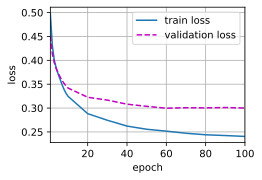

In [37]:
# TODO: your code here 
# Dropout = 0.25
num_hiddens3, num_layers3, dropout3, batch_size3, num_steps3 = 32, 2, 0.5, 64, 10
lr3, num_epochs3, device3 = 0.005, 100, d2l.try_gpu()
ffn_num_input3, ffn_num_hiddens3, num_heads3 = 32, 64, 4
key_size3, query_size3, value_size3 = 32, 32, 32
norm_shape3 = [32]

train_iter3, validation_iter3, src_vocab3, tgt_vocab3 = load_data_nmt(batch_size3, num_steps3, num_examples=10000)

encoder3 = TransformerEncoder(len(src_vocab3), key_size3, query_size3, value_size3,
                             num_hiddens3, norm_shape3, ffn_num_input3,
                             ffn_num_hiddens3, num_heads3, num_layers3, dropout3)
decoder3 = TransformerDecoder(len(tgt_vocab3), key_size3, query_size3, value_size3,
                             num_hiddens3, norm_shape3, ffn_num_input3,
                             ffn_num_hiddens3, num_heads3, num_layers3, dropout3)
net3 = d2l.EncoderDecoder(encoder3, decoder3)
train_seq2seq(net3, train_iter3, validation_iter3, lr3, num_epochs3, tgt_vocab3, device3)

train loss 0.240, 7210.8 validation loss 0.306 tokens/sec on cuda:0


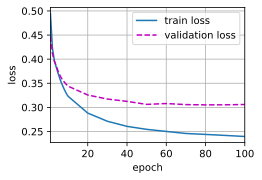

In [42]:
# TODO: your code here
# Droupout = 0.5
num_hiddens3, num_layers3, dropout3, batch_size3, num_steps3 = 32, 2, 0.5, 64, 10
lr3, num_epochs3, device3 = 0.005, 100, d2l.try_gpu()
ffn_num_input3, ffn_num_hiddens3, num_heads3 = 32, 64, 4
key_size3, query_size3, value_size3 = 32, 32, 32
norm_shape3 = [32]

train_iter3, validation_iter3, src_vocab3, tgt_vocab3 = load_data_nmt(batch_size3, num_steps3, num_examples=10000)

encoder3 = TransformerEncoder(len(src_vocab3), key_size3, query_size3, value_size3,
                             num_hiddens3, norm_shape3, ffn_num_input3,
                             ffn_num_hiddens3, num_heads3, num_layers3, dropout3)
decoder3 = TransformerDecoder(len(tgt_vocab3), key_size3, query_size3, value_size3,
                             num_hiddens3, norm_shape3, ffn_num_input3,
                             ffn_num_hiddens3, num_heads3, num_layers3, dropout3)
net3 = d2l.EncoderDecoder(encoder3, decoder3)
train_seq2seq(net3, train_iter3, validation_iter3, lr3, num_epochs3, tgt_vocab3, device3)

**(B) Discuss your result**

TODO: your observations here

In the presence of Dropout the model can generalize the learning better than the case of its absence. By raising the value of Dropout from 0.25 to 0.5, training loss reduced from 0.241 to 0.240 that is a negligible change. Also, the validation losses increased that made us keeping on with setting around 0.25.

**(C) Change the number of heads in the encoder and/or decoder. Do you see any difference in the results? What happens in extreme cases?**

train loss 0.171, 6981.9 validation loss 0.258 tokens/sec on cuda:0


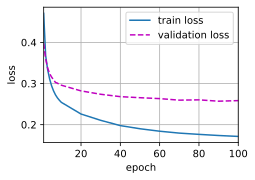

In [48]:
# TODO: your code here
num_hiddens4, num_layers4, dropout4, batch_size4, num_steps4 = 32, 2, 0.25, 64, 10
lr4, num_epochs4, device4 = 0.005, 100, d2l.try_gpu()
ffn_num_input4, ffn_num_hiddens4, num_heads4 = 32, 64, 8 #no. heads from 4 to 32
key_size4, query_size4, value_size4 = 32, 32, 32
norm_shape4 = [32]

train_iter4, validation_iter4, src_vocab4, tgt_vocab4 = load_data_nmt(batch_size4, num_steps4, num_examples=10000)

encoder4 = TransformerEncoder(len(src_vocab4), key_size4, query_size4, value_size4,
                             num_hiddens4, norm_shape4, ffn_num_input4,
                             ffn_num_hiddens4, num_heads4, num_layers4, dropout4)
decoder4 = TransformerDecoder(len(tgt_vocab4), key_size4, query_size4, value_size4,
                             num_hiddens4, norm_shape4, ffn_num_input4,
                             ffn_num_hiddens4, num_heads4, num_layers4, dropout4)
net4 = d2l.EncoderDecoder(encoder4, decoder4)
train_seq2seq(net4, train_iter4, validation_iter4, lr4, num_epochs4, tgt_vocab4, device4)

TODO: your answer here

By increasing the number of heads, both the training and validation loss decreased. We also decreased the number of heads that led to worse result related losses. So, we conculude, in multiplehead function increasing heads can be helpful to have a better overal result. Because more of them would help to have a longer-term memory.

**(D) Look at the `MultiHeadAttention` class. Does the number of trainable parameters change with the number of heads? And if so, how?**

TODO: your answer here

It does change the number of trainable parameters. Inside the forward step, the transpose_qkv is imposed to queries, keys and values based on the number of heads.

**(E) What happens if you change only one of the `key_size`, `query_size` or `value_size`? Can you explain why?**

RuntimeError: ignored

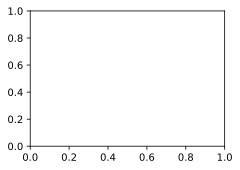

In [ ]:
# TODO: your code here
num_hiddens5, num_layers5, dropout5, batch_size5, num_steps5 = 32, 2, 0.25, 64, 10
lr5, num_epochs5, device5 = 0.005, 100, d2l.try_gpu()
ffn_num_input5, ffn_num_hiddens5, num_heads5 = 32, 64, 32
key_size5, query_size5, value_size5 = 32, 32, 64
norm_shape5 = [32]

train_iter5, validation_iter5, src_vocab5, tgt_vocab5 = load_data_nmt(batch_size5, num_steps5)

encoder5 = TransformerEncoder(len(src_vocab5), key_size5, query_size5, value_size5,
                             num_hiddens5, norm_shape5, ffn_num_input5,
                             ffn_num_hiddens5, num_heads5, num_layers5, dropout5)
decoder5 = TransformerDecoder(len(tgt_vocab5), key_size5, query_size5, value_size5,
                             num_hiddens5, norm_shape5, ffn_num_input5,
                             ffn_num_hiddens5, num_heads5, num_layers5, dropout5)
net5 = d2l.EncoderDecoder(encoder5, decoder5)
train_seq2seq(net5, train_iter5, validation_iter5, lr5, num_epochs5, tgt_vocab5, device5)

TODO: your answer here

An error occures when matrix multiplication is attempted inside the transpose_qkv() inside the MultiHeadAttention class, due to the differences in the shape of the two matrices $[a, b] \times [c, d], where\ should\ b = c$. This is happening because we have considered $p_q=p_k=p_v=p_o/h$ for simplification and by changing only one the code crashes.

## 4.4 Positional encoding

**(A) Explain in your own words why positional encoding is used in transformer networks.**

TODO: your answer here

Positional encoding helps us maintain the information of sequences orders, in parallel computing, by injecting absolute or relative positional information to the input.

**(B) Remove positional encoding from the network**

Hint: copy `TransformerEncoder` and `TransformerDecoder` below, and add a parameter to `__init__` that takes the type of positional encoding block. Then create your own `PositionalEncoding` block that does nothing

In [62]:
# TODO: your code here
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()

    def forward(self, X):
        return X

class TransformerEncoder(d2l.Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

train loss 0.056, 3812.2 validation loss 0.235 tokens/sec on cuda:0


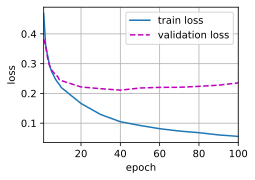

In [63]:
# TODO: your code here
num_hiddens6, num_layers6, dropout6, batch_size6, num_steps6 = 32, 2, 0.25, 64, 10
lr6, num_epochs6, device6 = 0.005, 100, d2l.try_gpu()
ffn_num_input6, ffn_num_hiddens6, num_heads6 = 32, 64, 8
key_size6, query_size6, value_size6 = 32, 32, 32
norm_shape6 = [32]

train_iter6, validation_iter6, src_vocab6, tgt_vocab6 = load_data_nmt(batch_size6, num_steps6)

encoder6 = TransformerEncoder(len(src_vocab6), key_size6, query_size6, value_size6,
                             num_hiddens6, norm_shape6, ffn_num_input6,
                             ffn_num_hiddens6, num_heads6, num_layers6, dropout6)
decoder6 = TransformerDecoder(len(tgt_vocab6), key_size6, query_size6, value_size6,
                             num_hiddens6, norm_shape6, ffn_num_input6,
                             ffn_num_hiddens6, num_heads6, num_layers6, dropout6)
net_nopos = d2l.EncoderDecoder(encoder6, decoder6)
train_seq2seq(net_nopos, train_iter6, validation_iter6, lr6, num_epochs6, tgt_vocab6, device6)

**(C) What happens if you don't use any positional encoding? Can you explain why?**

TODO: your observation and explanation here

Without positional encoding the model overfits quicker with the loss increasing higher than before.

**(D) Make a modified `calculate_validation_loss` function that shuffles the *input* words in each sample.  
Then calculate the shuffled validation loss. Does it make a difference if you use positional encoding?**

In [64]:
def shuffle_row(X, valid_len):
    """Shuffle the first valid_len elements of X"""
    perm = torch.randperm(valid_len)
    return torch.cat((X[perm], X[-1].repeat(len(X)-valid_len)))

def shuffle_rows(X, X_valid_len):
    return torch.stack([shuffle_row(X[i],X_valid_len[i]) for i in range(len(X))])

def calculate_validation_loss_shuffled_without(net, loss, validation_iter, tgt_vocab, device):
    # TODO: your code here
    metric = d2l.Accumulator(2)
    for batch in validation_iter:
        X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
        bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
        dec_input = torch.cat([bos, Y[:, :-1]], 1)
        Y_hat, _ = net(X, dec_input, X_valid_len)
        l = loss(Y_hat, Y, Y_valid_len)
        l.sum().backward()
        d2l.grad_clipping(net, 1)
        num_tokens = Y_valid_len.sum()
        with torch.no_grad():
            metric.add(l.sum(), num_tokens)
    print('Loss without shuffling:', metric[0] / metric[1])

def calculate_validation_loss_shuffled(net, loss, validation_iter, tgt_vocab, device):
    # TODO: your code here
    metric = d2l.Accumulator(2)
    for batch in validation_iter:
        X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
        X = shuffle_rows(X, X_valid_len)
        bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
        dec_input = torch.cat([bos, Y[:, :-1]], 1)
        Y_hat, _ = net(X, dec_input, X_valid_len)
        l = loss(Y_hat, Y, Y_valid_len)
        l.sum().backward()
        d2l.grad_clipping(net, 1)
        num_tokens = Y_valid_len.sum()
        with torch.no_grad():
            metric.add(l.sum(), num_tokens)
    print('Loss with shuffling:', metric[0] / metric[1])

print('Validation error without positional encoding:')
calculate_validation_loss_shuffled_without(net_nopos, d2l.MaskedSoftmaxCELoss(), validation_iter, tgt_vocab, device)
calculate_validation_loss_shuffled(net_nopos, d2l.MaskedSoftmaxCELoss(), validation_iter, tgt_vocab, device)
print('\nValidation error with positional encoding:')
calculate_validation_loss_shuffled_without(net, d2l.MaskedSoftmaxCELoss(), validation_iter, tgt_vocab, device)
calculate_validation_loss_shuffled(net, d2l.MaskedSoftmaxCELoss(), validation_iter, tgt_vocab, device)

Validation error without positional encoding:
Loss without shuffling: 0.09695016649274296
Loss with shuffling: 0.08966381876546961

Validation error with positional encoding:
Loss without shuffling: 0.2855166335878124
Loss with shuffling: 0.2857265410309875


TODO: your observations here

With shuffling the result is a little better when not using positional positional. In contrast, when using positional encoding the result is better without shuffling.

**(E) What happens if you also shuffle the target outputs `Y`? Can you explain that result?**

In [65]:
def shuffle_row(X, valid_len):
    """Shuffle the first valid_len elements of X"""
    perm = torch.randperm(valid_len)
    return torch.cat((X[perm], X[-1].repeat(len(X)-valid_len)))

def shuffle_rows(X, X_valid_len):
    return torch.stack([shuffle_row(X[i],X_valid_len[i]) for i in range(len(X))])

def calculate_validation_loss_shuffled_without_Y(net, loss, validation_iter, tgt_vocab, device):
    # TODO: your code here
    metric = d2l.Accumulator(2)
    for batch in validation_iter:
        X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
        X = shuffle_rows(X, X_valid_len)
        bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
        dec_input = torch.cat([bos, Y[:, :-1]], 1)
        Y_hat, _ = net(X, dec_input, X_valid_len)
        l = loss(Y_hat, Y, Y_valid_len)
        l.sum().backward()
        d2l.grad_clipping(net, 1)
        num_tokens = Y_valid_len.sum()
        with torch.no_grad():
            metric.add(l.sum(), num_tokens)
    print('Loss without shuffling Y:', metric[0] / metric[1])

def calculate_validation_loss_shuffled_with_Y(net, loss, validation_iter, tgt_vocab, device):
    # TODO: your code here
    metric = d2l.Accumulator(2)
    for batch in validation_iter:
        X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
        X = shuffle_rows(X, X_valid_len)
        Y = shuffle_rows(Y, Y_valid_len)
        bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
        dec_input = torch.cat([bos, Y[:, :-1]], 1)
        Y_hat, _ = net(X, dec_input, X_valid_len)
        l = loss(Y_hat, Y, Y_valid_len)
        l.sum().backward()
        d2l.grad_clipping(net, 1)
        num_tokens = Y_valid_len.sum()
        with torch.no_grad():
            metric.add(l.sum(), num_tokens)
    print('Loss with shuffling Y:', metric[0] / metric[1])

calculate_validation_loss_shuffled_without_Y(net_nopos, d2l.MaskedSoftmaxCELoss(), validation_iter, tgt_vocab, device)
calculate_validation_loss_shuffled_with_Y(net_nopos, d2l.MaskedSoftmaxCELoss(), validation_iter, tgt_vocab, device)

Loss without shuffling Y: 0.09172684285000794
Loss with shuffling Y: 0.8382705308302882


TODO: your observations and explanation here

Shuffling Y does not necessarily lead to better result. We can see that the loss considerably increased after Y shuffling.

## 4.5 Transformers vs. RNNs

Last week we looked at recurrent neural networks. Transformers are newer, but does newer mean better?

**(A) Compare the results of the transformer with the GRU network from d2l chapter 9.7.**

train loss 0.043, 5584.8 validation loss 0.211 tokens/sec on cuda:0


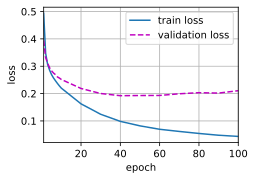

In [69]:
# TODO: your code here
# The Seq2SeqDecoder class had to be added here due to the d2l package that 
# could not find this class
class Seq2SeqDecoderG(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoderG, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state


embed_size7, num_hiddens7, num_layers7, dropout7 = 32, 32, 2, 0.25
batch_size7, num_steps7 = 64, 10
lr7, num_epochs7, device7 = 0.005, 100, d2l.try_gpu()

train_iter7, validation_iter7, src_vocab7, tgt_vocab7 = load_data_nmt(batch_size7, num_steps7)
encoder7 = d2l.Seq2SeqEncoder(len(src_vocab7), embed_size7, num_hiddens7, num_layers7,
                         dropout7)
decoder7 = Seq2SeqDecoderG(len(tgt_vocab7), embed_size7, num_hiddens7, num_layers7,
                         dropout7)
net7 = d2l.EncoderDecoder(encoder7, decoder7)
train_seq2seq(net7, train_iter7, validation_iter7, lr7, num_epochs7, tgt_vocab7, device7)

**(B) Discuss the differences**

TODO: your answer here

Comparing the results of the last network in this assignment with the GRU network from chapter 9.7, the GRU network shows better results. This can be seen by the learning curve of the validation loss, which rises slower when compared with the validation loss of this assignment.

## The end

Well done! Please double check the instructions at the top before you submit your results.